In [14]:
###########################################################################     
############################ model training ###############################
###########################################################################
import os
import sys
import shutil, errno
import zipfile as zf
import random
from glob import glob
from pathlib import Path

from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import confusion_matrix

inp = input('Are you compiling on google colab?, y/n: ')
if inp.lower() == "y":
    print("We are using google colab")
    ############## if compile on google colab #################
    !pip install import-ipynb
    import import_ipynb

    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    your_module = drive.CreateFile({'id':'1SHaQHVdU1XA9Jn3KKoFwpJt0v1EdIR_T'})
    # https://drive.google.com/open?id=1wCNx7SWrCPL78UmmzEF6pAfdniCVJUWS
    # https://drive.google.com/open?id=1WtBoScDx5eMdQKYwLAkUbpJyYUxrNFGw
    # https://drive.google.com/open?id=1UmFmSi9bU_uhArlFyVBz1SDiASMR67Gx
    # https://drive.google.com/open?id=1SHaQHVdU1XA9Jn3KKoFwpJt0v1EdIR_T
    your_module.GetContentFile('data_utils.ipynb')
    import data_utils as du
    
    
    print("Importing data from google drive")
    ############## if compile on google colab #################
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    drive.mount('/content/drive')

    # !ls "/content/drive/My Drive"
    # os.chdir("../")
    datapath = "./processed_data/"
    test_path = os.path.join(datapath, "test")
    valid_path = os.path.join(datapath, "valid")
    train_path = os.path.join(datapath, "train")
    folders = ["./original_data/", datapath, test_path, train_path, valid_path, "./trained_models/"]
    du.create_folders(folders)
    du.unzip("/content/drive/My Drive/VishvamData.zip")
    du.move_folder("./VishvamData/", "./original_data")
    du.copy_folder("./original_data/", train_path)

    du.split_into_train_valid_and_test_sets(datapath, 0.4, 0.5)


    path = Path(os.getcwd())/"processed_data"
    tfms = get_transforms(do_flip=True, flip_vert=True)
    data = ImageDataBunch.from_folder(path, test="test", ds_tfms=tfms, bs=16)


elif using_colab == 0:
    print("Importing data from local machine")
    ########## if compile locally ###############
    datapath = "./processed_data/"
    test_path = os.path.join(datapath, "test")
    valid_path = os.path.join(datapath, "valid")
    train_path = os.path.join(datapath, "train")
    folders = ["./original_data/", datapath, test_path, train_path, valid_path, "./trained_models/"]
    create_folders(folders)
    unzip("VishvamData.zip")
    move_folder("./VishvamData/", "./original_data")

    waste_types = ["compost", "recycle"]
    waste_paths = ["./original_data/"+ w + "/" for w in waste_types]
    create_folders(waste_paths)
    rename_and_move_images("./original_data/plastic/","./original_data/recycle/")
    rename_and_move_images("./original_data/metal/","./original_data/recycle/")
    rename_and_move_images("./original_data/glass/","./original_data/recycle/")
    rename_and_move_images("./original_data/cardboard/","./original_data/compost/")
    rename_and_move_images("./original_data/paper/","./original_data/compost/")

    copy_folder("./original_data/", train_path)

    split_into_train_valid_and_test_sets(datapath, 0.4, 0.5)


    path = Path(os.getcwd())/"processed_data"
    tfms = get_transforms(do_flip=True, flip_vert=True)
    data = ImageDataBunch.from_folder(path, test="test", ds_tfms=tfms, bs=16)

    
    
elif inp.lower() == "n":
    print("We are using local machine")
    ########## if compile locally ###############
    import data_utils as du
    
    data = du.process_data_vishvam(0)
else:
    print("Please reply y/n")
    


Are you compiling on google colab?, y/n: y
We are using google colab
Importing data from google drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Do you clear the folder ./original_data/?, y/n: y
The folder will be cleared
Do you clear the folder ./processed_data/?, y/n: y
The folder will be cleared

Created ./processed_data/test

Created ./processed_data/train

Created ./processed_data/valid
Do you clear the folder ./trained_models/?, y/n: y
The folder will be cleared
./processed_data/test/
['./processed_data/train/Recycling/', './processed_data/train/Compost/', './processed_data/train/Trash/']
['Recycling', 'Compost', 'Trash']
Recycling  -- size of non-trainset:  135 , size of trainset:  204
Compost  -- size of non-trainset:  127 , size of trainset:  191
Trash  -- size of non-trainset:  129 , size of trainset:  194
['./processed_data/valid/Recycling/', './processed_data/valid/Compost/', './processed_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


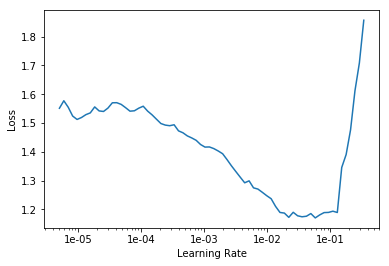

In [15]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

learn.model

learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(20,max_lr=2.46e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.323844,0.909112,0.426396,00:19
1,1.015139,0.503827,0.228426,00:20
2,0.741098,0.334974,0.147208,00:21
3,0.560674,0.202243,0.101523,00:21
4,0.411879,0.186024,0.076142,00:20
5,0.314180,0.077953,0.020305,00:21
6,0.248631,0.121626,0.035533,00:20
7,0.204598,0.074314,0.030457,00:20
8,0.154477,0.134868,0.050761,00:20
9,0.115341,0.159928,0.045685,00:21


In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

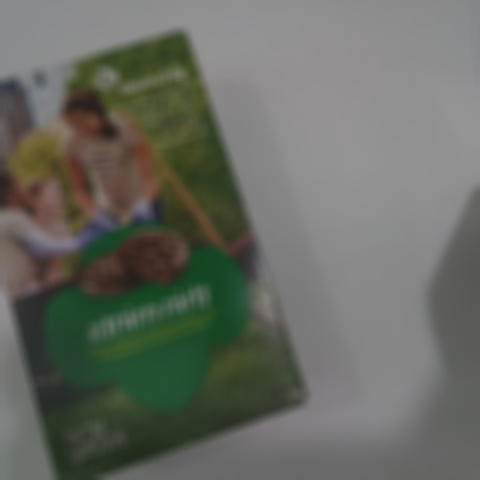

In [20]:
learn.data.test_ds[0][0]

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [0]:
temp = []
for a in y:
    if a == "ecycling":
        temp.append("Recycling")
    elif a == "rash":
        temp.append("Trash")
    else:
        temp.append("Compost")
        
y = temp

In [29]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['Recycling', 'Trash', 'Recycling', 'Recycling', 'Recycling']
['Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling']


In [30]:

cm = confusion_matrix(y,yhat)
print(cm)

[[63  0  0]
 [ 3 63  1]
 [ 3  0 61]]


In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [32]:
accuracy = correct/sum(sum(cm))
accuracy

0.9639175257731959

In [33]:
############## error analysis ###############
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.most_confused(min_val=2)

[('Recycling', 'Compost', 3), ('Recycling', 'Trash', 2)]

In [34]:
print(y)

['Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Recycling', 'Compost', 'Compost', 'Compost', 'Compost', 'Compost', 'Compost', 'Compost', 'Compost', 'Compost', 'Compost', 'Compost', 'Compos